In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

import sys
sys.path.append("../analysis/")
sys.path.append("../dsc/functions/")

import utils
import methodprops
import plot_functions as fplot
import simulate

from gradvi.models import basis_matrix as gv_basemat
from gradvi.optimize import moving_average as gvma
from mrashpen.utils import R_trendfilter
from mrashpen.inference.mrash_wrapR import MrASHR

In [3]:
gv_basemat.trendfiltering(10, 0)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [16]:
Hscale = gv_basemat.trendfiltering_scaled(10, 2)

In [17]:
np.diag(Hscale.T @ Hscale)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [13]:
Hscale[:, 1]

array([-0.49543369, -0.38533732, -0.27524094, -0.16514456, -0.05504819,
        0.05504819,  0.16514456,  0.27524094,  0.38533732,  0.49543369])

# Simulate time series data 

Current implementation can simulate degree 0, 1 and 2 only.

In [2]:
def timeseries(x, sfix, degree, snr = 2.0, signal = 'normal', bfix = None, seed = None):

    if seed is not None: np.random.seed(seed)
    n = x.shape[0]
    bidx = np.floor(np.linspace(0, n, sfix + 2)[1:-1]).astype(int)
    btrue_nz = simulate.sample_coefs(bidx.shape[0], np.arange(bidx.shape[0]), method = signal, bfix = bfix)

    btrue = np.zeros(n)
    btrue[bidx] = btrue_nz

    # Select a random initial slope, next ones are created from changepoints.
    slope = np.ones(x.shape[0]) * np.random.normal(0, 1, 1)
    for i, idx in enumerate(bidx):
        slope[idx:] = btrue_nz[i]

    # Generate time series data
    ytrue = slope.copy()
    if degree == 1:
        ytrue[0] = slope[0]
        for i in range(1, n):
            ytrue[i] = ytrue[i - 1] + slope[i]
    elif degree == 2:
        ytrue[0] = slope[0]
        ytrue[1] = slope[1]
        for i in range(2, n):
            ytrue[i] = 2 * ytrue[i-1] - ytrue[i-2] + slope[i]

    # Generate noise
    signal = np.sum(np.square(ytrue)) / n
    std = np.sqrt(signal) / snr  
    noise = np.random.normal(0, std, n)
    y = ytrue + noise
    return y, ytrue, btrue, std


In [51]:
n = 4096
sfix = 10
snr  = 5.0
degree = 0
x = np.linspace(0, 1, n)

y, ytest, ytrue, btrue, strue = simulate.timeseries(x, sfix, degree, snr)

# Compare changepoint slopes with linear regression coefficients

In [52]:
H = gv_basemat.trendfiltering(n, degree)
Hinv = gv_basemat.trendfiltering_inverse(n, degree)
Hscale = gv_basemat.trendfiltering_scaled(n, degree)
Hinvscale = gv_basemat.trendfiltering_inverse_scaled(n, degree)
b_linreg = np.dot(Hinv, ytrue)
b_linreg[np.abs(b_linreg) <= 1e-8] = 0.

In [53]:
tf_y, tf_fit = R_trendfilter.fit(y, order = degree)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



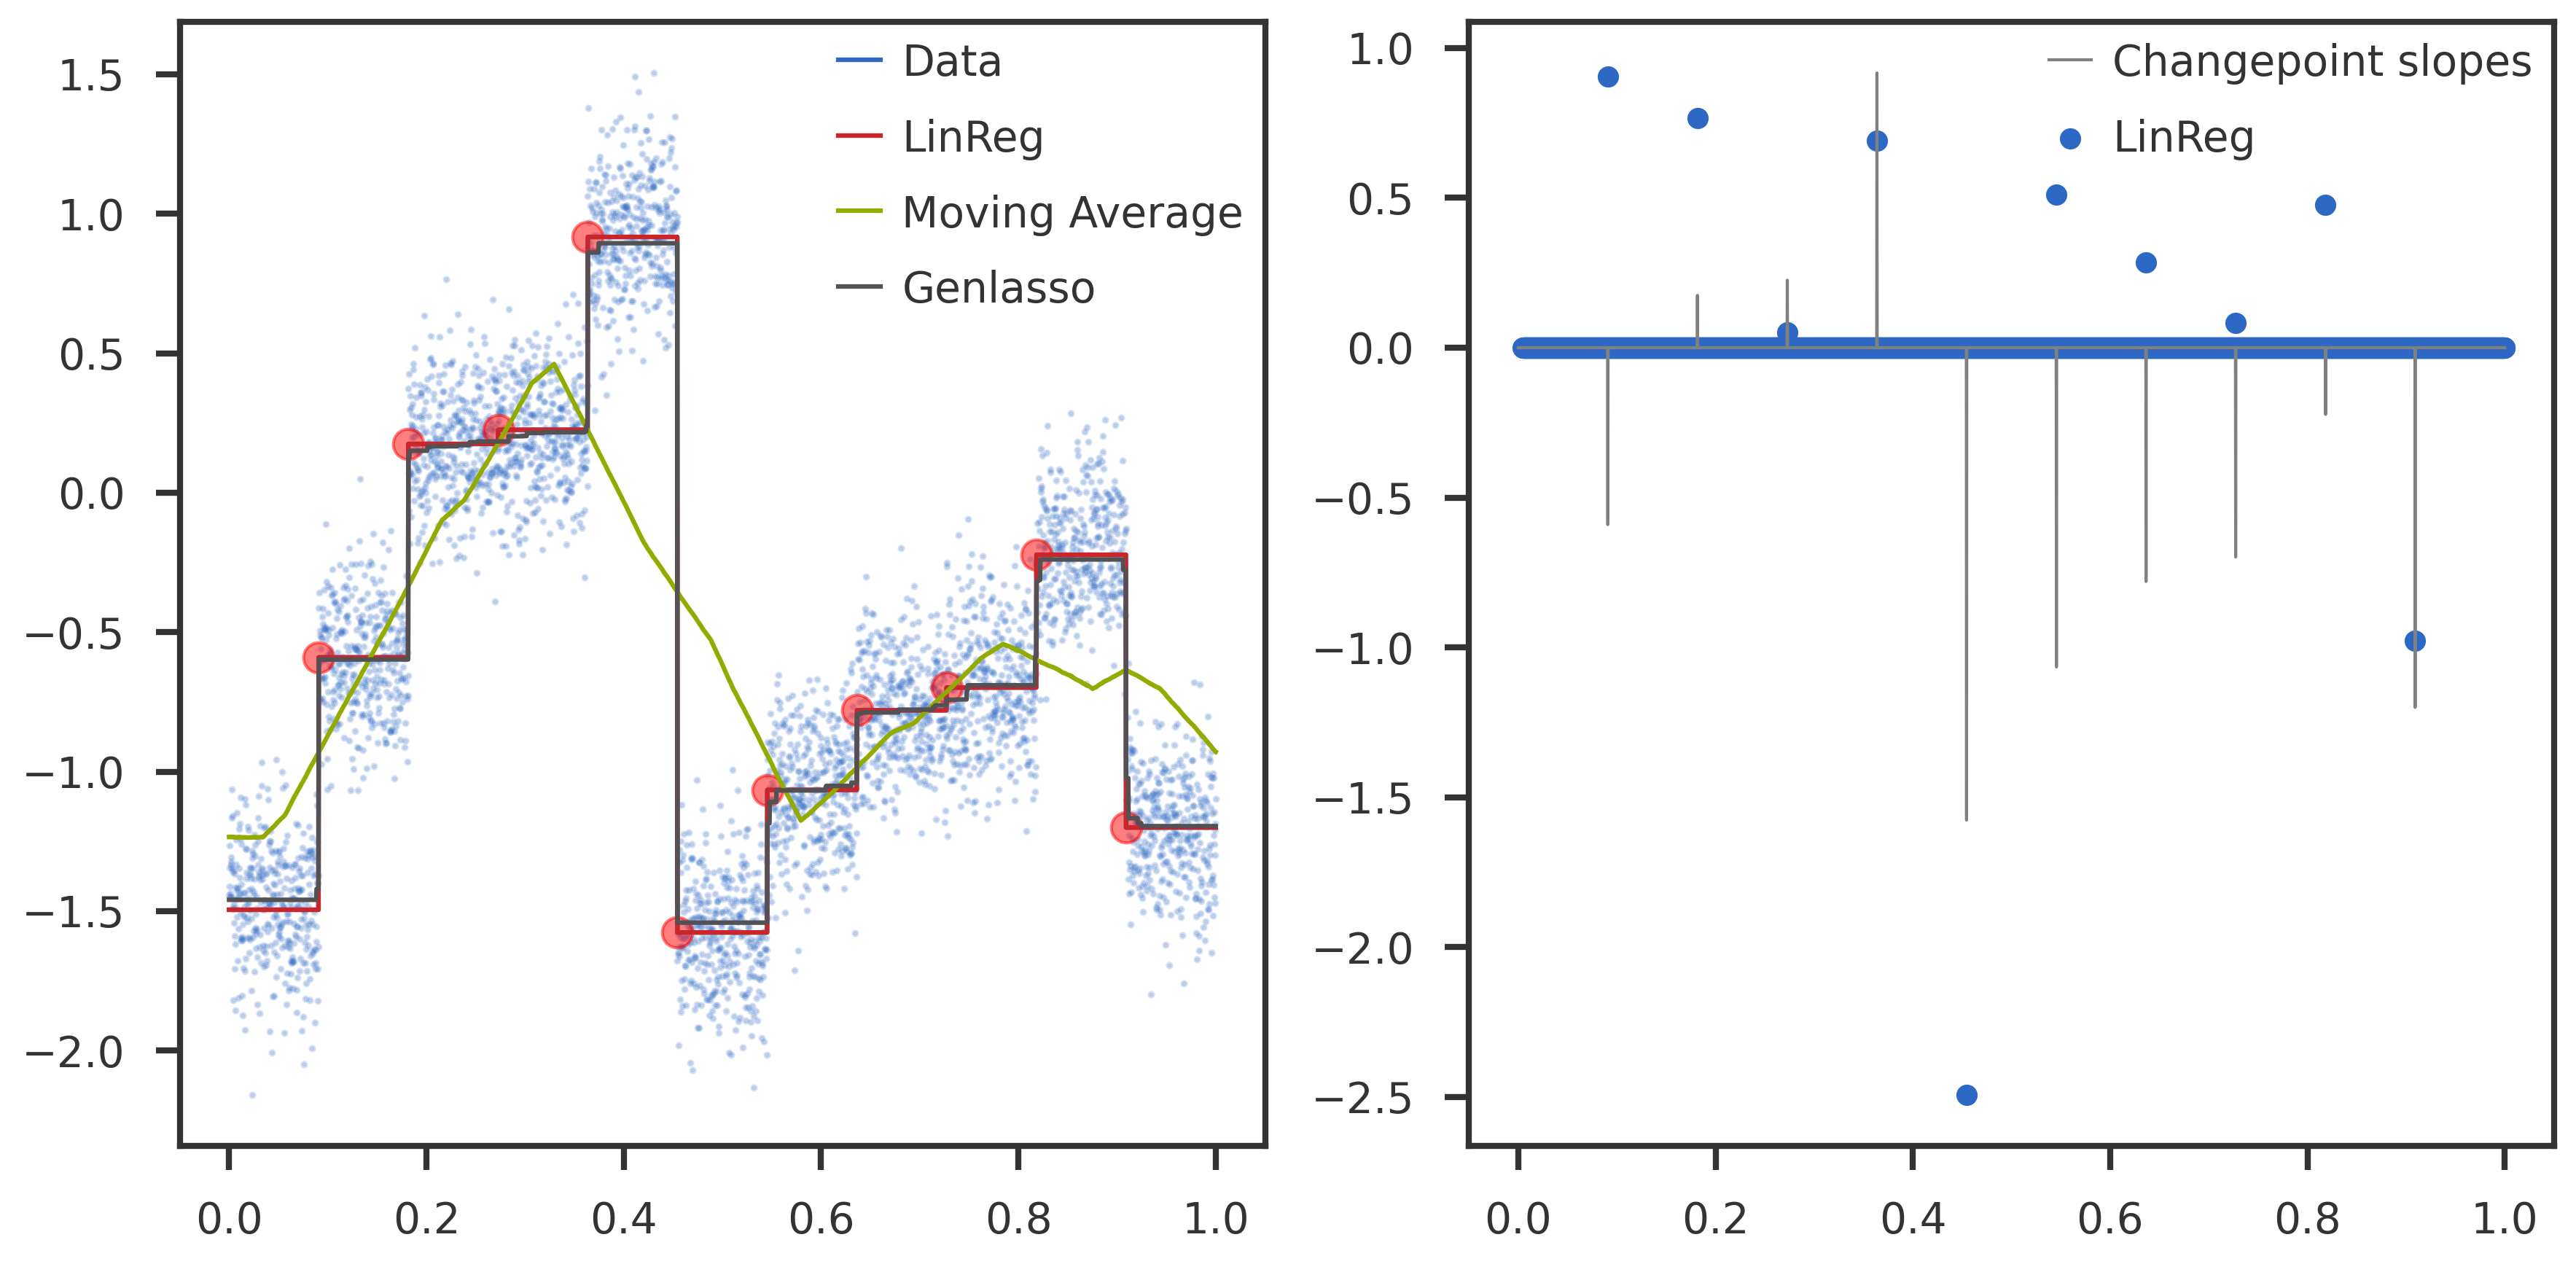

In [54]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

y_init = gvma.moving_average(y, n = 1024)

ax1.scatter(x, y, s = 2, alpha = 0.2)
ax1.plot (x, ytrue, label = 'Data')
for i, b in enumerate(btrue):
    if b != 0: ax1.scatter(x[i], ytrue[i], s = 100, c = 'red', marker = 'o', alpha = 0.5)
ax1.plot(x, np.dot(H, b_linreg), label = 'LinReg')
ax1.plot(x, y_init, label = 'Moving Average')
ax1.plot(x, tf_y, label = 'Genlasso')
ax1.legend()

ax2.plot(x, btrue, label = 'Changepoint slopes', lw = 1, c = 'grey')
ax2.scatter(x[20:], b_linreg[20:], label = 'LinReg')
ax2.legend()

plt.tight_layout()
plt.show()

# Solve using GradVI and CAVI

In [55]:
from fit_gradvi import fit_ash_trendfiltering_gradvi

# Prior definitions
skfactor = (degree + 1) * 20.0
ncomp = 20
sparsity = 0.99
skbase = 2.0

gv_compound_scaled = fit_ash_trendfiltering_gradvi(y, "reparametrize", degree = degree, 
                    yinit = y_init,
                    maxiter = 2000, tol = 1e-8,
                    ncomp = ncomp, sparsity = sparsity, skbase = skbase, skfactor = skfactor,
                    standardize_basis = True, scale_basis = True, standardize = True)

In [63]:
from fit_gradvi import get_ash
from gradvi.optimize import moving_average as gvma

prior_init = get_ash(k = ncomp, sparsity = sparsity, skbase = skbase, skfactor = skfactor)
b_init = np.dot(Hinv, y_init)
s2_init = np.var(y - y_init)
mrash_r = MrASHR(option = "rds", debug = True)
mrash_r.fit(H, y, prior_init.sk,
            binit = b_init, winit = prior_init.w_init, s2init = s2_init)

2023-07-03 19:19:51,540 | mrashpen.inference.mrash_wrapR | INFO | Mr.ASH terminated at iteration 1526.



In [64]:
mrash_r_ypred = np.dot(H, mrash_r.coef.reshape(-1,)) + mrash_r.intercept
mrash_r_elbo = mrash_r.fitobj['varobj']

In [58]:
gv_compound = fit_ash_trendfiltering_gradvi(y, "reparametrize", degree = degree, 
                    yinit = y_init,
                    maxiter = 2000, tol = 1e-8, 
                    ncomp = ncomp, sparsity = sparsity, skbase = skbase, skfactor = skfactor,
                    standardize_basis = False, scale_basis = False, standardize = True)

In [59]:
gv_direct_scaled = fit_ash_trendfiltering_gradvi(y, "direct", degree = degree,
                    yinit = y_init,
                    maxiter = 2000, tol = 1e-8,
                    ncomp = ncomp, sparsity = sparsity, skbase = skbase, skfactor = skfactor,
                    standardize_basis = True, scale_basis = False, standardize = True)

In [60]:
gv_compound_scaled_elbo = gv_compound_scaled[0]['elbo_path']
gv_compound_elbo = gv_compound[0]['elbo_path']
gv_direct_scaled_elbo = gv_direct_scaled[0]['elbo_path']

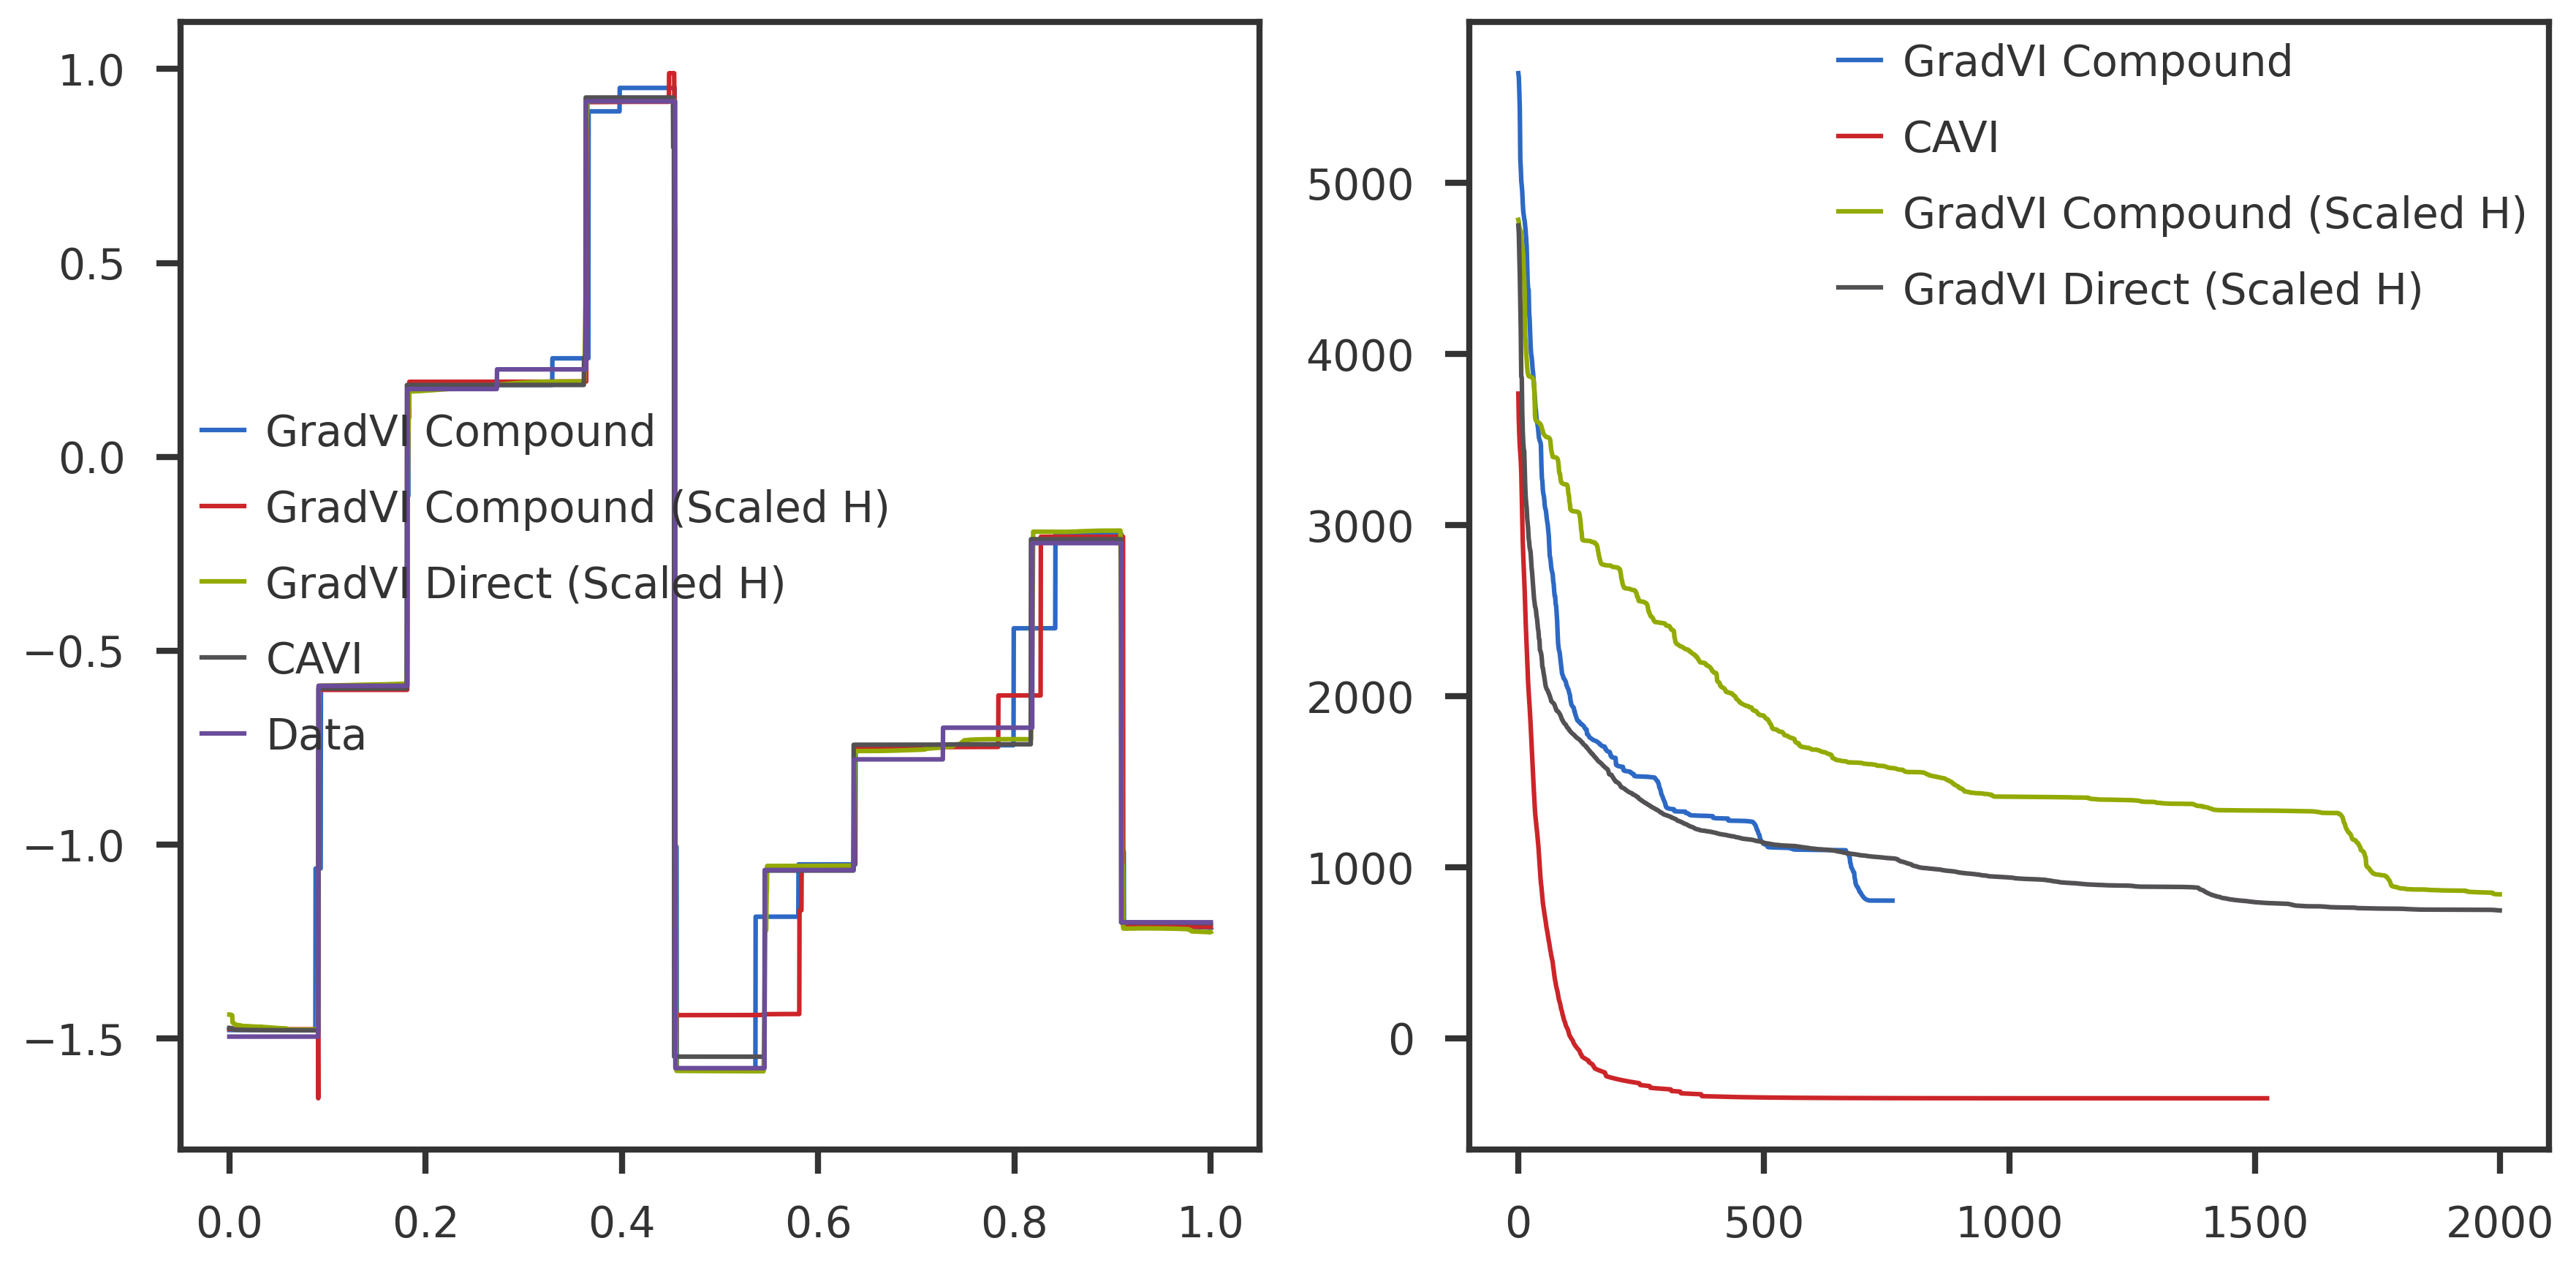

In [65]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#ax1.scatter(x, y, s = 2, alpha = 0.2)
ax1.plot(x, gv_compound[3], label = 'GradVI Compound')
ax1.plot(x, gv_compound_scaled[3], label = 'GradVI Compound (Scaled H)')
ax1.plot(x, gv_direct_scaled[3], label = 'GradVI Direct (Scaled H)')
ax1.plot(x, mrash_r_ypred, label = 'CAVI')
ax1.plot(x, ytrue, label = 'Data')
#ax1.plot(x, tf_y, label = 'Genlasso')
ax1.legend()

ax2.plot(np.arange(gv_compound_elbo.shape[0]), gv_compound_elbo, label = 'GradVI Compound')
ax2.plot(np.arange(mrash_r_elbo.shape[0]), mrash_r_elbo, label = 'CAVI')
ax2.plot(np.arange(gv_compound_scaled_elbo.shape[0]), gv_compound_scaled_elbo, label = 'GradVI Compound (Scaled H)')
ax2.plot(np.arange(gv_direct_scaled_elbo.shape[0]), gv_direct_scaled_elbo, label = 'GradVI Direct (Scaled H)')
ax2.legend()

plt.tight_layout()
plt.show()

# Fix trendfiltering ELBO difference

In [69]:
from gradvi.priors import Ash
_mrash_prior = Ash(prior_init.sk, wk = mrash_r.prior.reshape(-1,), scaled = False)
_mrash_ypred = mrash_r_ypred.copy()
_mrash_s2 = mrash_r.residual_var

In [143]:
from gradvi.inference import Trendfiltering
from gradvi.models import TrendfilteringModel

gv = Trendfiltering(
    obj = 'direct', maxiter = 10, tol = 1e-8, 
    standardize_basis = False, scale_basis = False, 
    standardize = True, get_elbo = False,
    optimize_b = True, optimize_s = False, optimize_w = False
)
gv.fit(y, degree, _mrash_prior, y_init = _mrash_ypred, s2_init = _mrash_s2)
gv.elbo_path

array([757.72502251, 757.29373544, 756.99077351, 756.8106121 ,
       756.74454147, 756.60659953, 756.53758698, 756.46953599,
       756.38912297, 756.27104349])

In [141]:
from gradvi.inference import LinearRegression

gv2 = LinearRegression(
    obj = 'direct', maxiter = 10, tol = 1e-8,
    optimize_b = False, optimize_s = True, optimize_w = False)
gv2.fit(H, y, _mrash_prior, b_init = mrash_r.coef.reshape(-1,), t_init = None, s2_init = _mrash_s2, dj = None)

In [142]:
gv2.elbo_path

array([5649.28129106, 5636.47515474, 5612.5951974 , 5611.64114043,
       5611.46029526, 5611.4594486 , 5611.45944802])

In [87]:
mrash_r.elbo_path[-1]

-350.18214847599216

In [88]:
mrash_r = MrASHR(option = "rds", debug = True)
mrash_r.fit(H, y, _mrash_prior.sk, maxiter = 2,
            binit = np.dot(Hinv, _mrash_ypred), winit = _mrash_prior.w_init, s2init = _mrash_s2)

2023-07-03 19:49:58,999 | mrashpen.inference.mrash_wrapR | INFO | Mr.ASH terminated at iteration 2.



In [89]:
mrash_r.elbo_path

array([-350.18217482, -350.18220101])

In [120]:
tfmodel = TrendfilteringModel(
    H, y, np.dot(Hinv, _mrash_ypred), _mrash_s2, _mrash_prior,
            dj = None,
            objtype = "reparametrize",
            v2inv = None,
            debug = False,
            invert_method = "trisection",
            invert_options = {},
            tf_degree = 0,
            tfbasis_matrix = H,
            tfbasis_scale_factors = (None, None),
            standardize_basis = False,
            scale_basis = False)

In [121]:
tfmodel.elbo(method = "mrash")

-333.21107356171945

In [122]:
tfmodel.objective

-15311.224662455035

In [123]:
tfmodel.objective + 0.5 * np.sum(np.log(tfmodel._dj))

-321.90063203300997